### Кривые проверки

Материал взят из книги "Python для сложных задач: наука о данных и машинное обучение" (Плас Дж. Вандер) и дополнен авторами курса.

Рассмотрим пример:

<a href="https://ibb.co/XySW9MF"><img src="https://i.ibb.co/HNnK03G/1.jpg" alt="1" border="0"></a>

Приведенная слева модель пытается найти прямолинейное приближение к данным. Но в силу того, что внутренняя структура данных сложнее прямой линии, с помощью прямолинейной модели невозможно описать этот набор данных достаточно 
хорошо. О подобной модели говорят, что она недообучена (underfit), то есть гибкость модели недостаточна для удовлетворительного учета всех признаков в данных. Другими словами, у этой модели имеется значительная систематическая ошибка.


Приведенная справа модель пытается подобрать для наших данных многочлен высокой степени. В этом случае модель достаточно гибка, чтобы практически идеально соответствовать всем нюансам данных, но хотя она и описывает очень точно обучающую последовательность, конкретная ее форма отражает скорее 
характеристики шума в данных, чем внутренние свойства процесса, сгенерировавшего данные. О подобной модели говорят, что она переобучена (overfit), то есть гибкость модели такова, что в конце концов модель учитывает не только исходное 
распределение данных, но и случайные ошибки в них. Другими словами, у этой модели имеется высокая дисперсия.

Проверочные кривые - это полезный инструмент для улучшения качества модели благодаря решению таких проблем, как переобучение или недообучение. 

Схематическое изображение зависимости между сложностью модели и оценками эффективности для обучения и проверки (кривая проверки):

<a href="https://ibb.co/30cS9Fn"><img src="https://i.ibb.co/cNQ2S8j/2.jpg" alt="2" border="0"></a>

- Оценка эффективности для обучения всегда превышает оценку эффективности для проверки. Это логично: модель лучше подходит для уже виденных ею данных, чем для тех, которые она еще не видела.  
- Модели с очень низкой сложностью (со значительной систематической ошибкой) являются недообученными, то есть эти модели будут плохо предсказывать как данные обучающей последовательности, так и любые ранее не виденные ими данные.  
- Модели с очень высокой сложностью (с высокой дисперсией) являются переобученными, то есть будут очень хорошо предсказывать данные обучающей последовательности, но на любых ранее не виденных данных работать очень плохо.  
- Кривая проверки достигает максимума в какой-то промежуточной точке. Этот уровень сложности означает приемлемый компромисс между систематической ошибкой и дисперсией.

validation_curve https://scikit-learn.org/stable/modules/learning_curve.html#validation-curve

### Рассмотрим на примере

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# make_pipeline работает как Pipeline, но не требует задавать имена, например, lr для LinearRegression

In [2]:
# Функция, которая возвращает конвейер
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [3]:
import numpy as np

# Даннная функция нужна для генерации точек данных
def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
         y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

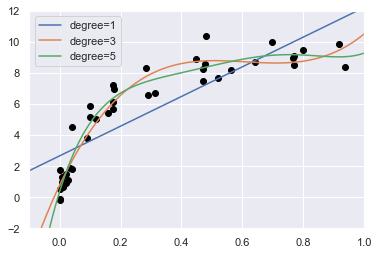

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() 

X_test = np.linspace(-0.1, 1.1, 500)[:, None]
plt.scatter(X.ravel(), y, color='black') # Точки данных 
axis = plt.axis()

# Для степеней 1,3,5
for degree in [1, 3, 5]:
    # трансформируем данные, обучаем модель и предсказываем значения для X_test
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)  
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree)) # отображаем на графике

plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Параметром, служащим для управления сложностью модели, в данном случае является степень многочлена, которая может быть любым неотрицательным числом.   
Не помешает задать себе вопрос: **какая степень многочлена обеспечивает подходящий компромисс между систематической ошибкой (недообучение) и дисперсией (переобучение)?**

Чтобы решить этот вопрос, визуализируем кривую проверки для этих конкретных данных и моделей.  
Проще всего сделать это с помощью validation_curve предоставляемой библиотекой Scikit-Learn. Эта функция, получив на входе модель, данные, название параметра и диапазон для анализа, автоматически 
вычисляет в этом диапазоне значение как оценки эффективности для обучения, так и оценки эффективности для проверки.

Функция validation_curve для оценки работоспособности модели использует перекрестную проверку.   
Внутри функции validation_curve мы указываем модель, данные (X и y), параметр, который мы хотели бы оценить, количество блоков (cv).

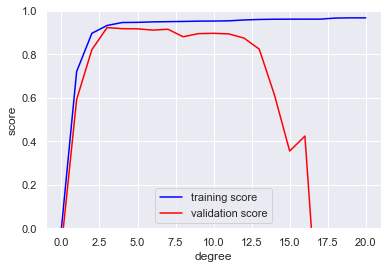

In [5]:
from sklearn.model_selection import validation_curve # импортируем validation_curve

degree = np.arange(0, 21)


train_score, val_score = validation_curve(PolynomialRegression(), X, y, 'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score') # Оценка обучения
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score') # Оценка проверки
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree') # Степень
plt.ylabel('score'); # Оценка

Этот график в точности демонстрирует ожидаемое нами качественное поведение: оценка эффективности для обучения на всем диапазоне превышает оценку эффективности для проверки. 
Оценка эффективности для обучения монотонно растет с ростом сложности модели, а оценка эффективности для проверки достигает максимума перед резким спадом в точке, где модель становится переобученной. Как можно понять из приведенной кривой проверки, оптимальный компромисс между систематической ошибкой и дисперсией достигается для многочлена третьей степени.

Вычислить и отобразить на графике эту аппроксимацию на исходных данных можно следующим образом:

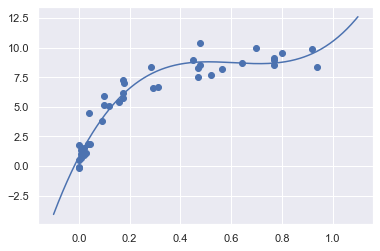

In [6]:
plt.scatter(X.ravel(), y)
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)

Отмечу, что для нахождения оптимальной модели не требуется вычислять оценку эффективности для обучения, но изучение зависимости между оценками эффективности для обучения и проверки дает нам полезную информацию относительно 
эффективности модели.

Дополнительно:  
Кривые обучения https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html